# Analyzing Student Responses to Circuits Questions using Latent Dirichlet Allocation

### Jon Geiger

## I. Introduction: Topic Modeling for Student Reponses in Physics

In this notebook, we will perform a machine learning analysis of student responses to a particular conceptual question about circuits in undergraduate physics. 

We will be using Latent Dirichlet Allocation (LDA) to pull out topics, which should represent student ideas. Much of the code and process for this analysis can be credited to Tor Odden and Allesandro Marin at the University of Oslo, who have graciously provided a Jupyter Notebook outlining the process of cleaning and modeling data from 18 years' worth of PERC proceedings (https://github.com/uio-ccse/PERC_TopicModel). Changes have been made as necessary, and certain modeling techniques have been excluded, such as the time variance of topics, as well as providing exemplary documents for each modeled topic. 

## II. Data Cleaning and Preparation

### Setting Notebook Options

In [1]:
# Print out all expressions
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Wider Cells
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# Ignore some warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning);

### Importing Packages

In [2]:
# General Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re

# NLP Packages
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary

import nltk
from nltk.corpus import wordnet
from nltk import pos_tag

# Download NLTK data
nltk.download('wordnet', quiet = True)
nltk.download('punkt', quiet = True) 
nltk.download('averaged_perceptron_tagger', quiet = True)
nltk.download('omw-1.4', quiet = True)

# Custom Helper Functions
from helper_functions import plot_freq_dist,get_top_n_words,plot_words_freq

True

True

True

True

### Importing and Cleaning Data

For the purposes of our investigation, we found that many student reponses included some form of the equation of Ohm's Law. These took the three distinct forms of $V=IR$, $I=V/R$, and $R=V/I$. Because all of these represent student ideas, we will treat each of them as a "word" in our analysis. 

In [3]:
df = pd.read_csv('compare_bulbs.csv', names = ['ID', 'resp'])
df.drop(columns = ['ID'], inplace = True)
df.head(5)

,resp
0,Circuit 2 has a larger battery that has a grea...
1,If the voltage is increased but resistance rem...
2,Current is equal to charge over time. Move vol...
3,An increase in voltage indicates an increase i...
4,Voltage is the change in electric potential. C...


In [4]:
def ML_process(text): 
    filt_text = text
    
    # Clean up equations
    filt_text = re.sub('(V|v)\s?=\s?(I|i)\s?\*?\s?(R|r)', 'VequalsItimesR', filt_text)
    filt_text = re.sub('(I|i)\s?=\s?(V|v)\s?/\s?(R|r)', 'IequalsVoverR', filt_text)
    filt_text = re.sub('(R|r)\s?=\s?(V|v)\s?/\s?(I|i)', 'RequalsVoverI', filt_text)
    #filt_text = re.sub('\s?=\s?', '=', filt_text)
    
    # Replace variables with names outside of equations
    filt_text = re.sub('\s(V|v)\s', ' voltage ', filt_text)
    filt_text = re.sub('\s(R|r)\s', ' resistance ', filt_text)  
    # can't do this with current because 'I' is a pronoun
    
    # Remove quotes, commas, periods, parentheses
    filt_text = re.sub('[",\.\(\)]', '', filt_text)
    # Remove single quotes
    filt_text = re.sub("'", '', filt_text)
    
    

    return filt_text

df['replaced'] = df.resp.map(lambda x: ML_process(x))

Let's process our data and look at an example of what the cleaning process did. 

In [5]:
df['resp'].loc[420]
df['replaced'].loc[420]

"More voltage leads to greater current as when rearranged, Ohm's law is I = V/R, so if V increases, I will also increase.  I manipulate the mathematical model in order to get a specific set of conditions in order to solve the problem."

'More voltage leads to greater current as when rearranged Ohms law is IequalsVoverR so if voltage increases I will also increase  I manipulate the mathematical model in order to get a specific set of conditions in order to solve the problem'

I've decided to replace any equation form of Ohm's law with a word which represents that form of the equation. In this response, the student used $I = V/R$, which I have replaced with `IequalsVoverR`. This is because if the word contains symbols, the preprocessor will eliminate it in the next steps. So, there is a one-to-one mapping between any form of the equation and a new "word" such as `IequalsVoverR` or `VequalsItimesR`.

We can notice that it changed "V" to "voltage," but it did not change "I" to "current." This is because "I" is also a pronoun and is often indistinguishable from the variable when used in informally-written physics sentences. In fact, this student used "I" in the same sentence to mean two different things. With regular expressions, it's nearly impossible to distinguish whether this "I" refers to the person or the current. 

### Removing Stopwords, Lemmatizing, and Making Bigrams

In [6]:
def sent_to_words(list_sentences):
    return [gensim.utils.simple_preprocess(str(sentence), deacc=True) for sentence in list_sentences] 

def remove_stopwords(tokens):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in STOPWORDS ] for doc in tokens]

def get_wordnet_pos(word): #Provide a POS tag
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) #return NOUN by default

def lemmatize_token(token):
    return nltk.stem.WordNetLemmatizer().lemmatize(token, get_wordnet_pos(token))

def lemmatize(token_list):
    '''Input example: ["he", "matches", "the", "profile"]'''
    return [lemmatize_token(token) for token in token_list]

In [7]:
# Tokenize reponses
data_words = sent_to_words(df['replaced'])

In [8]:
# Remove stopwords
data_words_nostops = remove_stopwords(data_words)

In [9]:
# Lemmatize
data_words_lemmatized = [lemmatize(token_list) for token_list in data_words_nostops] 

In [10]:
# Make bigrams
phrases = gensim.models.phrases.Phrases(data_words_lemmatized, min_count = 10)
bigram = gensim.models.phrases.Phraser(phrases)

def make_bigrams(list_tokenized_docs): 
    return [bigram[doc] for doc in list_tokenized_docs]

data_words_bigrams = make_bigrams(data_words_lemmatized)

The response from above has now become the following: 

In [11]:
print("Original: \n", df['resp'].loc[420], sep = "")
print()
print("Cleaned & Replaced: \n", df['replaced'].loc[420], sep = "")
print()
print("Tokenized: \n", data_words[420], sep = "")
print()
print("No Stops: \n", data_words_nostops[420], sep = "")
print()
print("Lemmatized: \n", data_words_lemmatized[420], sep = "")
print()
print("Bigrams: \n", data_words_bigrams[420], sep = "")

Original: 
More voltage leads to greater current as when rearranged, Ohm's law is I = V/R, so if V increases, I will also increase.  I manipulate the mathematical model in order to get a specific set of conditions in order to solve the problem.

Cleaned & Replaced: 
More voltage leads to greater current as when rearranged Ohms law is IequalsVoverR so if voltage increases I will also increase  I manipulate the mathematical model in order to get a specific set of conditions in order to solve the problem

Tokenized: 
['more', 'voltage', 'leads', 'to', 'greater', 'current', 'as', 'when', 'rearranged', 'ohms', 'law', 'is', 'iequalsvoverr', 'so', 'if', 'voltage', 'increases', 'will', 'also', 'increase', 'manipulate', 'the', 'mathematical', 'model', 'in', 'order', 'to', 'get', 'specific', 'set', 'of', 'conditions', 'in', 'order', 'to', 'solve', 'the', 'problem']

No Stops: 
['voltage', 'leads', 'greater', 'current', 'rearranged', 'ohms', 'law', 'iequalsvoverr', 'voltage', 'increases', 'increa

### Plotting top words in all documents

In [12]:
corpus = [ w for doc in data_words_bigrams for w in doc ]
print('Total words: \033[1m%d\033[0m, unique words: \033[1m%d\033[0m' % (len(corpus), len(set(corpus))))

Total words: 8038, unique words: 870


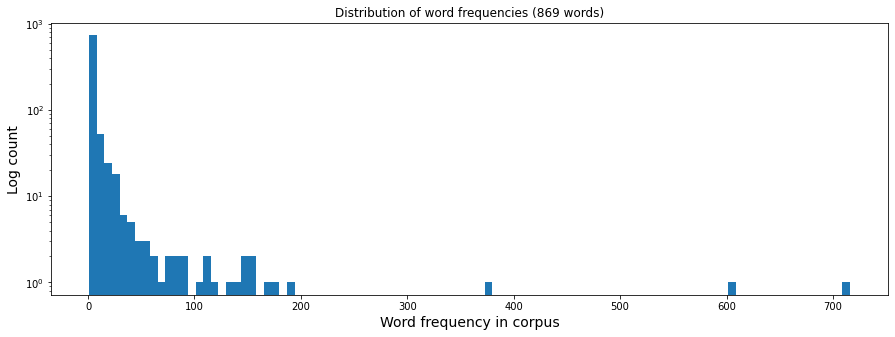

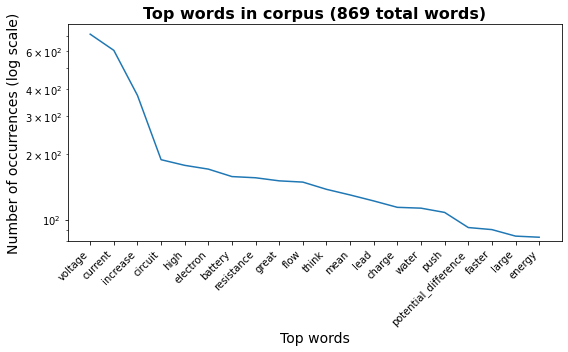

In [13]:
[words, freq, ids] = get_top_n_words(corpus, n_top_words=None)
fig = plot_freq_dist(freq)
fig, ax = plot_words_freq(words, freq)

### Choosing our Filtering Parameters

We want to filter out the extremely common and uncommon words, so we will change values of `no_above` and `no_below` to see which words are removed using different values. 

#### Testing the `no_above` Threshold

In [14]:
import copy

no_above_values = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

# NO ABOVE filtering object
id2word_unfiltered_above = gensim.corpora.Dictionary(data_words_bigrams) #Needed for a bug
id2word_unfiltered_above.filter_extremes(no_below=0, no_above=1, keep_n=100000)
print("Dictionary with \033[1mno_above=1\033[0m contains \033[1m%d\033[0m unique words\n" % (len(id2word_unfiltered_above)))

# Initial Filtering
no_above = 1.0
id2word = gensim.corpora.Dictionary(data_words_bigrams)
id2word.filter_extremes(no_below=0, no_above=no_above, keep_n=100000)
diff_set = set(list(id2word_unfiltered_above.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))


# Other Values of no_above
for val in no_above_values: 
    no_below = 0
    no_above = val
    id2word_prev = copy.deepcopy(id2word)
    id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
    diff_set = set(list(id2word_prev.values())) - set(list(id2word.values()))
    print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
          (no_above, len(id2word), len(diff_set), sorted(diff_set)))


Dictionary with no_above=1 contains 870 unique words

Dictionary filtered with no_above=1.00 contains 870 unique words. 0 words removed:
 [] 

Dictionary filtered with no_above=0.90 contains 870 unique words. 0 words removed:
 [] 

Dictionary filtered with no_above=0.80 contains 869 unique words. 1 words removed:
 ['voltage'] 

Dictionary filtered with no_above=0.70 contains 868 unique words. 1 words removed:
 ['current'] 

Dictionary filtered with no_above=0.60 contains 868 unique words. 0 words removed:
 [] 

Dictionary filtered with no_above=0.50 contains 868 unique words. 0 words removed:
 [] 

Dictionary filtered with no_above=0.40 contains 868 unique words. 0 words removed:
 [] 

Dictionary filtered with no_above=0.30 contains 867 unique words. 1 words removed:
 ['increase'] 

Dictionary filtered with no_above=0.20 contains 857 unique words. 10 words removed:
 ['battery', 'circuit', 'electron', 'flow', 'great', 'high', 'lead', 'mean', 'resistance', 'think'] 

Dictionary filtered 

#### Testing the `no_below` Threshold

In [15]:
no_below_values = [i for i in range(2, 30)]# 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1]

# NO BELOW filtering object
id2word_unfiltered_below = gensim.corpora.Dictionary(data_words_bigrams) #Needed for a bug
id2word_unfiltered_below.filter_extremes(no_below=1, no_above=no_above, keep_n=100000)
print("Dictionary with \033[1mno_below=1\033[0m contains \033[1m%d\033[0m unique words\n" % (len(id2word_unfiltered_below)))



# Initial filtering 
no_below = 1
id2word = gensim.corpora.Dictionary(data_words_bigrams)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000)
diff_set = set(list(id2word_unfiltered_below.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_below=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_below, len(id2word), len(diff_set), sorted(diff_set)))


# Other values of no_below

for val in no_below_values: 
    no_above = 1
    no_below = val
    id2word_prev = copy.deepcopy(id2word)
    id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
    diff_set = set(list(id2word_prev.values())) - set(list(id2word.values()))
    print("Dictionary filtered with \033[1mno_below=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
          (no_below, len(id2word), len(diff_set), sorted(diff_set)))

Dictionary with no_below=1 contains 847 unique words

Dictionary filtered with no_below=1.00 contains 847 unique words. 0 words removed:
 [] 

Dictionary filtered with no_below=2.00 contains 401 unique words. 446 words removed:
 ['aa', 'absorbed', 'accept', 'accumulate', 'accumulation', 'accurately', 'achieves', 'actual', 'adjust', 'aircraft', 'aka', 'akin', 'alarm', 'algebra', 'algebraically', 'alleviate', 'amp', 'analogous', 'anyways', 'apology', 'application', 'applies', 'arrow', 'ask', 'assign', 'attack', 'attempt', 'average', 'back', 'badly', 'bae', 'bateries', 'batter', 'bbbbbbbbb', 'bc', 'bear', 'bed', 'begin', 'bit', 'blub', 'boost', 'bottle', 'boy', 'breach', 'break', 'bridge', 'brightening', 'brightest', 'brought', 'brunk', 'buld', 'burn', 'burning', 'buzzing', 'cabin', 'cancel', 'cap', 'catch', 'caught', 'cave', 'cell', 'chance', 'charger', 'check', 'chemical', 'circulate', 'circut', 'class', 'classify', 'clear', 'cliff', 'close', 'closer', 'collectively', 'color', 'combine'

We will choose a `no_above` value of 1 (for now) and a `no_below` value of 3. 

For our `no_above` value, we are choosing not to exclude the most common words (current and voltage) because we are trying to characterize student ideas about current and voltage. If we can relate these words to other terms, perhaps we can extract some useful information. 

For our `no_below` value, we want to include as many words as possible which might lead us toward ideas which students have. We can notice that `no_below=4.00` excludes words such as "mass," "density," "length," "steep," and "property." All of these terms are not directly related to the problem, but provide insight into student ideas. Thus, since we do not want to remove these values, we choose `no_below=3.00`. 

### Creating our Bag of Words

We will now create the bag of words corpus which will be fed to our LDA model in the next section, using the thresholds defined in the previous part. 

Unfiltered Dictionary contains 870 unique words

Applying no_above=1 and no_below=3 removes 579 words:
 ['aa', 'absorbed', 'accelerate', 'accept', 'account', 'accumulate', 'accumulation', 'accurate', 'accurately', 'achieves', 'actual', 'actually', 'addition', 'additionally', 'additive', 'adjust', 'affected', 'air', 'aircraft', 'aka', 'akin', 'alarm', 'algebra', 'algebraically', 'alleviate', 'amp', 'analogous', 'anyways', 'apology', 'application', 'applies', 'arrange', 'arrow', 'ask', 'assign', 'associate', 'attack', 'attempt', 'attract', 'attraction', 'average', 'away', 'back', 'badly', 'bae', 'bateries', 'batter', 'bbbbbbbbb', 'bc', 'bear', 'becasue', 'becuase', 'bed', 'begin', 'best', 'bit', 'block', 'blub', 'boost', 'bottle', 'boulder', 'boy', 'breach', 'break', 'bridge', 'bright', 'brightening', 'brightest', 'brought', 'brunk', 'built', 'buld', 'burn', 'burning', 'buzzing', 'cabin', 'calculate', 'cancel', 'cap', 'catch', 'caught', 'cave', 'cell', 'chance', 'charger', 'check', 'chem

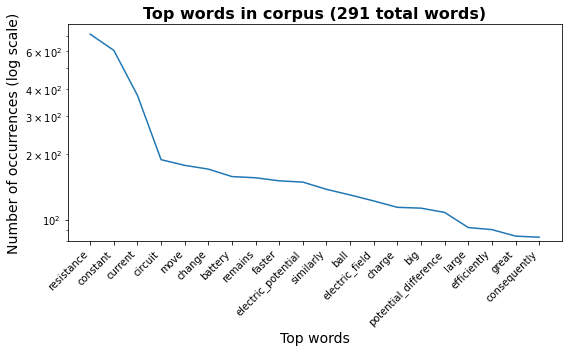

(<Figure size 576x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Top words in corpus (291 total words)'}, xlabel='Top words', ylabel='Number of occurrences (log scale)'>)

In [16]:
no_above = 1
no_below = 3

id2word_unfiltered = gensim.corpora.Dictionary(data_words_bigrams) #Needed for a bug
print("Unfiltered Dictionary contains \033[1m{}\033[0m unique words".format(len(id2word_unfiltered)))

id2word = gensim.corpora.Dictionary(data_words_bigrams)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000)

#Effect of using no_above
diff_set = set(list(id2word_unfiltered.values())) - set(list(id2word.values()))
print("\nApplying \033[1mno_above={} and no_below={} removes {} words\033[0m:\n {} \n".format(no_above, no_below, len(diff_set), sorted(diff_set)))

id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000) #NB: no problem filtering again on no_above
print("Filtered Dictionary contains \033[1m{}\033[0m unique words\n".format(len(id2word)))

#Create BoW
bow_corpus = [id2word.doc2bow(doc) for doc in data_words_bigrams]

#Get most frequent words from id2word Dictionary
#There is a bug with csf: https://github.com/RaRe-Technologies/gensim/issues/2574
[ids, freq] = zip(*sorted(id2word.cfs.items(), key=lambda x: x[1], reverse=True))
words = [id2word_unfiltered[id] for id in ids]  #have to use id2word_unfiltered to retrieve words from ids!!

# Plot distribution
plot_words_freq(words, freq, 20, ylim=None)

These filtering parameters are not necessarily chosen optimally, but rather by intuition of what may yield good topics. Note that choosing different filtering parameters may drastically impact the topics produced by the LDA model.

## III. Topic Modeling

### Training the Model

### Evaluating Model Coherence

### Dominant Topic in each Document (optional)

### Representative Document for each Topic (optional)